<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 708, '日付': '2021-05-03T08:00:00.000Z'},
 {'小計': 609, '日付': '2021-05-04T08:00:00.000Z'},
 {'小計': 621, '日付': '2021-05-05T08:00:00.000Z'},
 {'小計': 591, '日付': '2021-05-06T08:00:00.000Z'},
 {'小計': 907, '日付': '2021-05-07T08:00:00.000Z'},
 {'小計': 1121, '日付': '2021-05-08T08:00:00.000Z'},
 {'小計': 1032, '日付': '2021-05-09T08:00:00.000Z'},
 {'小計': 573, '日付': '2021-05-10T08:00:00.000Z'},
 {'小計': 925, '日付': '2021-05-11T08:00:00.000Z'},
 {'小計': 969, '日付': '2021-05-12T08:00:00.000Z'},
 {'小計': 1010, '日付': '2021-05-13T08:00:00.000Z'},
 {'小計': 854, '日付': '2021-05-14T08:00:00.000Z'},
 {'小計': 772, '日付': '2021-05-15T08:00:00.000Z'},
 {'小計': 542, '日付': '2021-05-16T08:00:00.000Z'},
 {'小計': 419, '日付': '2021-05-17T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-05-13 17:00:00+09:00,637,0,1010,2021-05-13 17:00:00+09:00
2021-05-14 17:00:00+09:00,597,0,854,2021-05-14 17:00:00+09:00
2021-05-15 17:00:00+09:00,645,0,772,2021-05-15 17:00:00+09:00
2021-05-16 17:00:00+09:00,511,0,542,2021-05-16 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-05-13 17:00:00+09:00,637,0,1010,2021-05-13 17:00:00+09:00,670.428571,4693.0,0.0,0.0,933.857143,6537.0
2021-05-14 17:00:00+09:00,597,0,854,2021-05-14 17:00:00+09:00,644.428571,4511.0,0.0,0.0,926.285714,6484.0
2021-05-15 17:00:00+09:00,645,0,772,2021-05-15 17:00:00+09:00,632.285714,4426.0,0.0,0.0,876.428571,6135.0
2021-05-16 17:00:00+09:00,511,0,542,2021-05-16 17:00:00+09:00,613.285714,4293.0,0.0,0.0,806.428571,5645.0
2021-05-17 17:00:00+09:00,0,0,419,2021-05-17 17:00:00+09:00,515.000000,3605.0,0.0,0.0,784.428571,5491.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-05-03 17:00:00+09:00,672,0,708,2021-05-03 17:00:00+09:00,662.000000,4634.0,0.0,0.0,873.571429,6115.0,'21w18,Mon
2021-05-04 17:00:00+09:00,682,0,609,2021-05-04 17:00:00+09:00,664.571429,4652.0,0.0,0.0,842.285714,5896.0,'21w18,Tue
2021-05-05 17:00:00+09:00,736,0,621,2021-05-05 17:00:00+09:00,678.285714,4748.0,0.0,0.0,798.857143,5592.0,'21w18,Wed
2021-05-06 17:00:00+09:00,1077,0,591,2021-05-06 17:00:00+09:00,746.428571,5225.0,0.0,0.0,736.571429,5156.0,'21w18,Thu
2021-05-07 17:00:00+09:00,779,0,907,2021-05-07 17:00:00+09:00,761.714286,5332.0,0.0,0.0,766.428571,5365.0,'21w18,Fri
2021-05-08 17:00:00+09:00,730,0,1121,2021-05-08 17:00:00+09:00,761.285714,5329.0,0.0,0.0,776.571429,5436.0,'21w18,Sat
2021-05-09 17:00:00+09:00,644,0,1032,2021-05-09 17:00:00+09:00,760.000000,5320.0,0.0,0.0,798.428571,5589.0,'21w18,Sun
2021-05-10 17:00:00+09:00,688,0,573,2021-05-10 17:00:00+09:00,762.285714,5336.0,0.0,0.0,779.142857,5454.0,'21w19,Mon
2021-05-11 17:00:00+09:00,593,0,925,2021-05-11 17:00:00+09:00,749.571429,5247.0,0.0,0.0,824.285714,5770.0,'21w19,Tue
2021-05-12 17:00:00+09:00,622,0,969,2021-05-12 17:00:00+09:00,733.285714,5133.0,0.0,0.0,874.000000,6118.0,'21w19,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-05-02 17:00:00+09:00,833.142857,5832
2021-05-09 17:00:00+09:00,798.428571,5589
2021-05-16 17:00:00+09:00,806.428571,5645
2021-05-17 17:00:00+09:00,419.000000,419
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-05-03 17:00:00+09:00,672,0,708,2021-05-03 17:00:00+09:00,662.000000,4634.0,0.0,0.0,873.571429,6115.0,'21w18,Mon,NaN,NaN
2021-05-04 17:00:00+09:00,682,0,609,2021-05-04 17:00:00+09:00,664.571429,4652.0,0.0,0.0,842.285714,5896.0,'21w18,Tue,NaN,NaN
2021-05-05 17:00:00+09:00,736,0,621,2021-05-05 17:00:00+09:00,678.285714,4748.0,0.0,0.0,798.857143,5592.0,'21w18,Wed,NaN,NaN
2021-05-06 17:00:00+09:00,1077,0,591,2021-05-06 17:00:00+09:00,746.428571,5225.0,0.0,0.0,736.571429,5156.0,'21w18,Thu,NaN,NaN
2021-05-07 17:00:00+09:00,779,0,907,2021-05-07 17:00:00+09:00,761.714286,5332.0,0.0,0.0,766.428571,5365.0,'21w18,Fri,NaN,NaN
2021-05-08 17:00:00+09:00,730,0,1121,2021-05-08 17:00:00+09:00,761.285714,5329.0,0.0,0.0,776.571429,5436.0,'21w18,Sat,NaN,NaN
2021-05-09 17:00:00+09:00,644,0,1032,2021-05-09 17:00:00+09:00,760.000000,5320.0,0.0,0.0,798.428571,5589.0,'21w18,Sun,798.428571,5589.0
2021-05-10 17:00:00+09:00,688,0,573,2021-05-10 17:00:00+09:00,762.285714,5336.0,0.0,0.0,779.142857,5454.0,'21w19,Mon,NaN,NaN
2021-05-11 17:00:00+09:00,593,0,925,2021-05-11 17:00:00+09:00,749.571429,5247.0,0.0,0.0,824.285714,5770.0,'21w19,Tue,NaN,NaN
2021-05-12 17:00:00+09:00,622,0,969,2021-05-12 17:00:00+09:00,733.285714,5133.0,0.0,0.0,874.000000,6118.0,'21w19,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

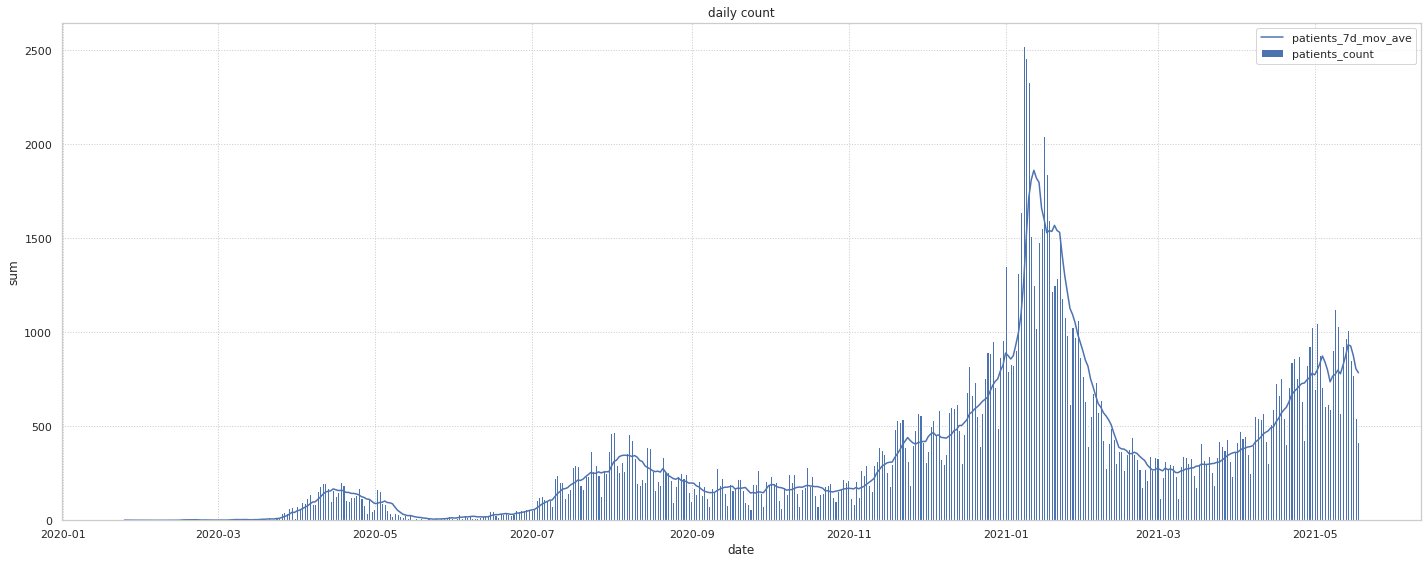

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
465,1.620029e+09,2021,5,3,0,1,0,0,0,0,0,465,0,391,672,662.000000,4634.0,0,0.0,0.0,708,873.571429,6115.0
466,1.620115e+09,2021,5,4,0,0,0,0,0,1,0,466,0,392,682,664.571429,4652.0,0,0.0,0.0,609,842.285714,5896.0
467,1.620202e+09,2021,5,5,0,0,0,0,0,0,1,467,0,393,736,678.285714,4748.0,0,0.0,0.0,621,798.857143,5592.0
468,1.620288e+09,2021,5,6,0,0,0,0,1,0,0,468,0,394,1077,746.428571,5225.0,0,0.0,0.0,591,736.571429,5156.0
469,1.620374e+09,2021,5,7,1,0,0,0,0,0,0,469,0,395,779,761.714286,5332.0,0,0.0,0.0,907,766.428571,5365.0
470,1.620461e+09,2021,5,8,0,0,1,0,0,0,0,470,0,396,730,761.285714,5329.0,0,0.0,0.0,1121,776.571429,5436.0
471,1.620547e+09,2021,5,9,0,0,0,1,0,0,0,471,0,397,644,760.000000,5320.0,0,0.0,0.0,1032,798.428571,5589.0
472,1.620634e+09,2021,5,10,0,1,0,0,0,0,0,472,0,398,688,762.285714,5336.0,0,0.0,0.0,573,779.142857,5454.0
473,1.620720e+09,2021,5,11,0,0,0,0,0,1,0,473,0,399,593,749.571429,5247.0,0,0.0,0.0,925,824.285714,5770.0
474,1.620806e+09,2021,5,12,0,0,0,0,0,0,1,474,0,400,622,733.285714,5133.0,0,0.0,0.0,969,874.000000,6118.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            480 non-null    float64
 1   year                 480 non-null    int64  
 2   month                480 non-null    int64  
 3   day                  480 non-null    int64  
 4   Fri                  480 non-null    uint8  
 5   Mon                  480 non-null    uint8  
 6   Sat                  480 non-null    uint8  
 7   Sun                  480 non-null    uint8  
 8   Thu                  480 non-null    uint8  
 9   Tue                  480 non-null    uint8  
 10  Wed                  480 non-null    uint8  
 11  passed               480 non-null    int64  
 12  emergency            480 non-null    int64  
 13  em_passed            480 non-null    int64  
 14  contacts_count       480 non-null    int64  
 15  contacts_7d_mov_ave  480 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.800000e+02,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,1.600546e+09,2020.285417,5.720833,15.639583,0.143750,0.143750,0.143750,0.143750,0.141667,0.141667,0.141667,239.500000,0.102083,171.281250,677.614583,674.990129,4724.922917,767.747917,767.747917,5374.235417,318.037500,313.916458,2197.381250
std,1.198440e+07,0.452084,3.383181,8.829473,0.351202,0.351202,0.351202,0.351202,0.349072,0.349072,0.349072,138.708327,0.303074,130.388588,442.913531,430.434948,3013.057118,874.904693,781.576877,5471.038137,375.261555,354.195255,2479.396889
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.590199e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,119.750000,0.000000,45.750000,389.250000,388.285714,2718.000000,0.000000,0.000000,0.000000,56.500000,53.892857,377.250000
50%,1.600546e+09,2020.000000,5.000000,15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,239.500000,0.000000,165.500000,551.000000,564.714286,3953.000000,359.500000,872.214286,6105.500000,206.000000,190.357143,1332.500000
75%,1.610892e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,359.250000,0.000000,285.250000,788.000000,779.571429,5457.000000,1387.000000,1385.500000,9698.500000,419.000000,415.821429,2910.750000
max,1.621238e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,479.000000,1.000000,405.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000,0.782218,0.094153,-0.023702,-0.004436,0.004436,-0.001479,0.001479,0.002932,-0.002932,0.000000e+00,1.000000e+00,-0.344323,0.994885,-0.269987,-0.254355,-0.254349,-0.509099,-0.548601,-0.548601,0.633097,0.669829,0.669845
year,0.782218,1.000000,-0.544284,-0.066225,0.004027,0.004027,0.004027,0.004027,-0.005402,-0.005402,-5.401889e-03,7.822178e-01,-0.213095,0.804078,-0.256675,-0.234944,-0.234941,-0.555167,-0.621460,-0.621460,0.600216,0.655157,0.655157
month,0.094153,-0.544284,1.000000,-0.011552,-0.013595,0.000461,-0.008324,-0.004810,0.012345,0.005274,8.809364e-03,9.415308e-02,-0.120781,0.052052,0.050286,0.036360,0.036364,0.204144,0.258514,0.258514,-0.109487,-0.149043,-0.149022
day,-0.023702,-0.066225,-0.011552,1.000000,0.013377,-0.010187,-0.002108,0.003951,0.003054,-0.006429,-1.687738e-03,-2.370187e-02,0.002076,-0.023136,-0.013036,-0.012034,-0.012038,0.019273,0.005213,0.005213,-0.019846,-0.011619,-0.011634
Fri,-0.004436,0.004027,-0.013595,0.013377,1.000000,-0.167883,-0.167883,-0.167883,-0.166460,-0.166460,-1.664598e-01,-4.435527e-03,-0.000858,-0.003347,-0.016956,-0.003790,-0.003789,0.034837,-0.002503,-0.002503,0.046008,-0.001656,-0.001665
Mon,0.004436,0.004027,0.000461,-0.010187,-0.167883,1.000000,-0.167883,-0.167883,-0.166460,-0.166460,-1.664598e-01,4.435527e-03,-0.000858,0.004586,0.030138,-0.001510,-0.001509,0.144348,-0.002503,-0.002503,-0.122822,0.002488,0.002490
Sat,-0.001479,0.004027,-0.008324,-0.002108,-0.167883,-0.167883,1.000000,-0.167883,-0.166460,-0.166460,-1.664598e-01,-1.478509e-03,-0.000858,-0.000702,0.047478,-0.002518,-0.002517,-0.171439,-0.002503,-0.002503,0.063369,0.000193,0.000186
Sun,0.001479,0.004027,-0.004810,0.003951,-0.167883,-0.167883,-0.167883,1.000000,-0.166460,-0.166460,-1.664598e-01,1.478509e-03,-0.000858,0.001942,-0.020486,-0.001510,-0.001509,-0.158129,-0.002503,-0.002503,-0.034051,0.001487,0.001486
Thu,0.002932,-0.005402,0.012345,0.003054,-0.166460,-0.166460,-0.166460,-0.166460,1.000000,-0.165049,-1.650485e-01,2.931947e-03,0.001151,0.001829,-0.003927,0.004380,0.004381,0.046026,0.003357,0.003357,0.076985,0.001560,0.001566
Tue,-0.002932,-0.005402,0.005274,-0.006429,-0.166460,-0.166460,-0.166460,-0.166460,-0.165049,1.000000,-1.650485e-01,-2.931947e-03,0.001151,-0.003492,-0.023776,0.001881,0.001882,0.061838,0.003357,0.003357,-0.037302,-0.003212,-0.003208


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1.620893e+09,0,0,0,0,1,0,0,475,0,401,637,0,1010,933.857143,6537.0
476,1.620979e+09,1,0,0,0,0,0,0,476,0,402,597,0,854,926.285714,6484.0
477,1.621066e+09,0,0,1,0,0,0,0,477,0,403,645,0,772,876.428571,6135.0
478,1.621152e+09,0,0,0,1,0,0,0,478,0,404,511,0,542,806.428571,5645.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
475,1.620893e+09,475,0,1010,933.857143,6537.0
476,1.620979e+09,476,0,854,926.285714,6484.0
477,1.621066e+09,477,0,772,876.428571,6135.0
478,1.621152e+09,478,0,542,806.428571,5645.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

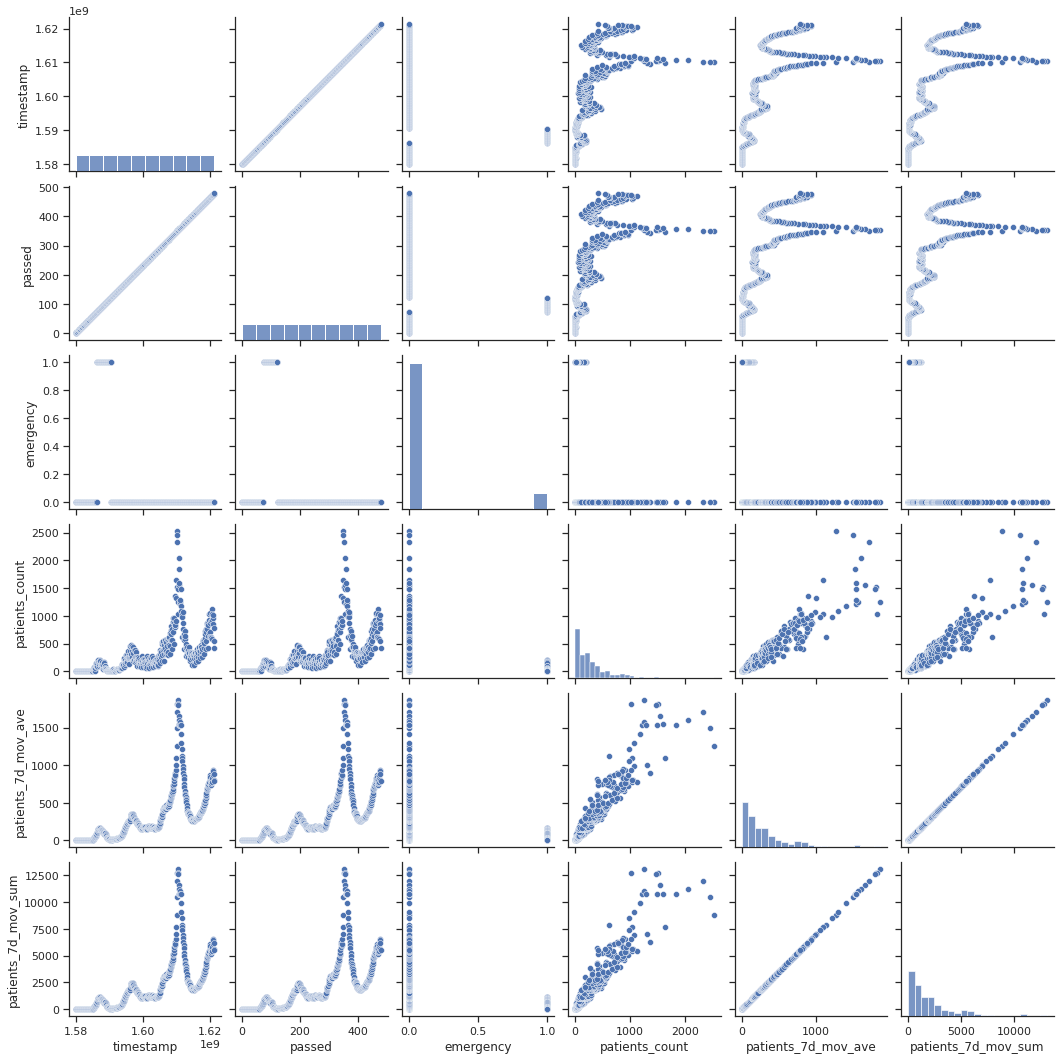

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
